<a href="https://colab.research.google.com/github/amirhoseinoveis/GradCAM-with-MSTAR/blob/main/GradCAM_with_MSTAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import tensorflow as tf
from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib
import matplotlib.pyplot as plt
import os
from tensorflow.keras import losses, layers
import keras
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(42)

In [21]:

github_url = 'https://raw.githubusercontent.com/amirhoseinoveis/LIME_with_MSTAR/7f0ea0868eec651540c373570060728392070ff5/mstar_3cl_32by32.npz'

# Download the file using wget
path = '/content/mstar_3cl_32by32.npz'
os.system(f'wget {github_url} -O {path}')

# Load the data using np.load
with np.load(path) as data_mstar:
    x_train_mstar = data_mstar['x_train']
    y_train_mstar = data_mstar['y_train']
    x_test_mstar = data_mstar['x_test']
    y_test_mstar = data_mstar['y_test']



In [ ]:
inputs = Input(shape=(32,32,1),name="Input")
x = Conv2D(128, 9, activation="relu", padding='same',name='Conv1')(inputs)
x = MaxPooling2D(2,name='Pool1')(x)
x = Conv2D(32, 7, activation="relu",padding='same',name='Conv3')(x)
x = MaxPooling2D(2,name='Pool2')(x)
x = Conv2D(16, 5, activation="relu",padding='same',name='Conv4')(x)
x = MaxPooling2D(2,name='Pool3')(x)

x = Flatten(name='Vectorize')(x)
outputs= Dense(3,name='FC',activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()




hist = model.fit(
x_train_mstar,
to_categorical(y_train_mstar, 3),  # One-hot encode your labels
batch_size=32,
epochs=10,
validation_split=0.15,
shuffle='on',
)


#classification_report
CM=confusion_matrix(y_true=y_test_mstar,y_pred=y_hat.argmax(1))
# Display confusion matrix
print("Confusion Matrix:")
print(CM)
print("classification_report:")

print(classification_report(y_true=y_test_mstar,y_pred=y_hat.argmax(1)))


In [44]:
def get_gradcam_heatmap(model, image, class_idx, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]

    # Gradient of the output neuron (target class) with respect to conv layer output
    grads = tape.gradient(loss, conv_outputs)[0]

    # Mean intensity of the gradient over each feature map channel
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Weighted sum of feature maps
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

    # Apply ReLU
    cam = tf.nn.relu(cam).numpy()

    # Normalize between 0 and 1
    cam -= cam.min()
    cam /= cam.max() + 1e-8

    return cam

def show_gradcam_overlay(input_image, heatmap, alpha=0.3):
    # Normalize heatmap to 0-255 and convert to RGB
    heatmap = np.uint8(255 * heatmap)

    # Resize heatmap to match the input image size
    heatmap_resized = cv2.resize(heatmap, (input_image.shape[1], input_image.shape[0]))

    # Apply a color map (e.g., jet)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Convert input grayscale image to 3 channels
    input_image_rgb = np.uint8(255 * input_image.squeeze())
    input_image_rgb = cv2.cvtColor(input_image_rgb, cv2.COLOR_GRAY2BGR)

    # Blend the heatmap with the input image
    overlay = cv2.addWeighted(heatmap_colored, alpha, input_image_rgb, 1 - alpha, 0)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(input_image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM")
    plt.imshow(input_image.squeeze(), cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay
    plt.axis('off')
    plt.tight_layout()

    plt.subplot(1, 3,3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


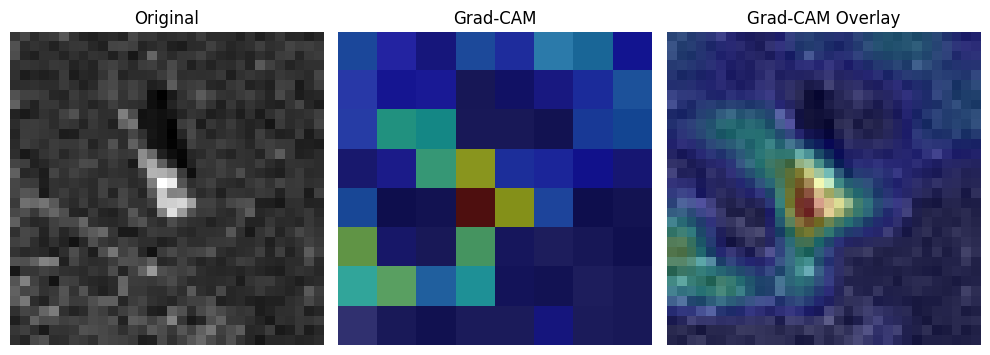

In [45]:
img_idx = 0
input_image = x_test_mstar[img_idx]  # shape: (H, W, 1)
true_label = y_test_mstar[img_idx]
preds = model.predict(np.expand_dims(input_image, axis=0))
pred_class = np.argmax(preds[0])

# Select the last conv layer (modify as needed)
last_conv_layer = "Conv4"

# Get heatmap
heatmap = get_gradcam_heatmap(model, input_image, pred_class, last_conv_layer)
show_gradcam_overlay(input_image, heatmap)



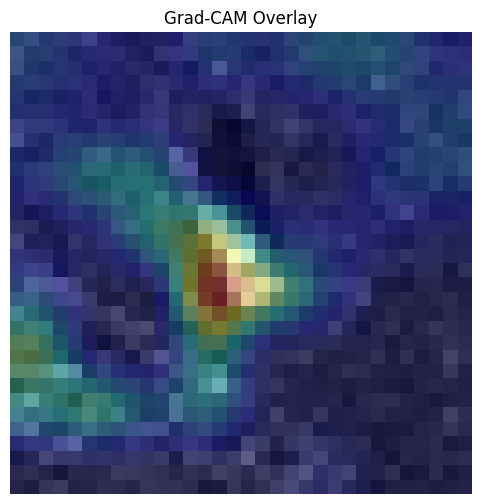

In [3]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img =( jet_heatmap * alpha + img)
    superimposed_img/=superimposed_img.max()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img)

    plt.subplot(1, 3, 2)
    plt.title('Grad-CAM Heatmap')
    plt.imshow(heatmap, cmap='jet')

    plt.subplot(1, 3, 3)
    plt.title('Overlay of Grad-CAM')
    plt.imshow(superimposed_img)


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 32, 32, 128)    │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 16, 16, 32)     │       200,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 8, 8, 16)       │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Vectorize (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC (Dense)                      │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,819 (878.20 KB)

 Trainable params: 224,819 (878.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - acc: 0.3907 - loss: 1.0541 - val_acc: 0.5714 - val_loss: 0.8262
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.6537 - loss: 0.7423 - val_acc: 0.7810 - val_loss: 0.5272
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - acc: 0.8069 - loss: 0.4852 - val_acc: 0.7524 - val_loss: 0.4647
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9035 - loss: 0.2771 - val_acc: 0.9714 - val_loss: 0.1426
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.9752 - loss: 0.1119 - val_acc: 0.9714 - val_loss: 0.1114
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.9805 - loss: 0.0714 - val_acc: 0.9905 - val_loss: 0.0723
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9817 - loss: 0.0419 - val_acc: 0.9905 - val_loss: 0.0431
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9937 - loss: 0.0259 - val_acc: 0.9905 - val_loss: 0.0448
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.994

In [17]:
classes_in=[0,1,2]
y_hat=model.predict(x_test_mstar)#test the model, prob.


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Confusion Matrix:
[[268   6   0]
 [  0 274   0]
 [  5   2 267]]
classification_report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       274
           1       0.97      1.00      0.99       274
           2       1.00      0.97      0.99       274

    accuracy                           0.98       822
   macro avg       0.98      0.98      0.98       822
weighted avg       0.98      0.98      0.98       822



In [19]:
x_test=np.copy(x_test_mstar)
image_size=(32,32)

model.layers[-1].activation = None
for i in range(0,10,1) :

    img_array=x_test[i:i+1]
    print(y_test_mstar[i:i+1])
    #preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name= "Conv4")

    heatmap = tf.image.resize(heatmap[..., tf.newaxis], image_size)
    heatmap = tf.squeeze(heatmap).numpy()



    save_and_display_gradcam(np.squeeze(np.uint8(255 *  img_array)), heatmap)


[0]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['Input']
Received: inputs=Tensor(shape=(1, 32, 32, 1))
  warnings.warn(msg)


ValueError: operands could not be broadcast together with shapes (32,32,3) (32,32) 

In [ ]:
img_array.min()

0.0196078431372549